In [175]:
%load_ext autoreload
%autoreload 2

import torch, click, numpy as np

import swyft
from utils import *
from plot import *

from tqdm import tqdm



DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
m = 1
nsub = 3
nsim = 25000

nmbins = 4

lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [3]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub3_nsim25000 exists!
Loading existing store.
Store has 24938 simulations.
Image has L = 40.


In [4]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m1_nsub3_nsim25000_nmbins4_lr-3.0_fac-1.0_pat5.pt!


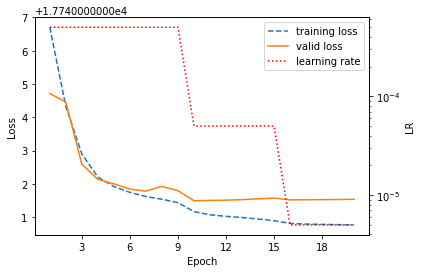

In [5]:
plot_losses(mre)

In [6]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    
    coord_full = []
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coord_full.append(coord)

    coords = [coord_empty] + coord_full
    return coords, coord_empty, coord_full, m_centers, m_edges 

def get_obs(store, i = -1):
    obs0_i = np.random.randint(0, len(store)) if i == -1 else i
    print(f'i = {obs0_i}')
    
    obs0 = store[obs0_i][0]
    v0 = store[obs0_i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coords, coord_empty, coord_full, m_centers, m_edges = get_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [7]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.99953125
pario halo 	0.00046875


In [226]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(store, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = torch.stack([
        mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
    ])
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    
    # Target coordinates
    x, y = v0[0][::3].numpy(), v0[0][1::3].numpy()
    m_i = np.where(targets[nmbins:] == 1)[0]
    target_coords = np.array((m_i, x, y)).T
    
    scatter = np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [1, 2, 0]])
    
    return posts_norm[nmbins:], target_coords, scatter



## Final results

i = 787


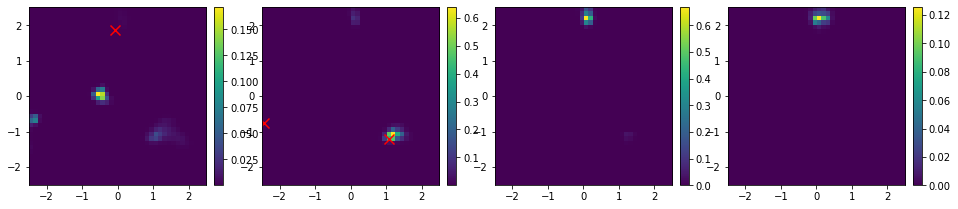

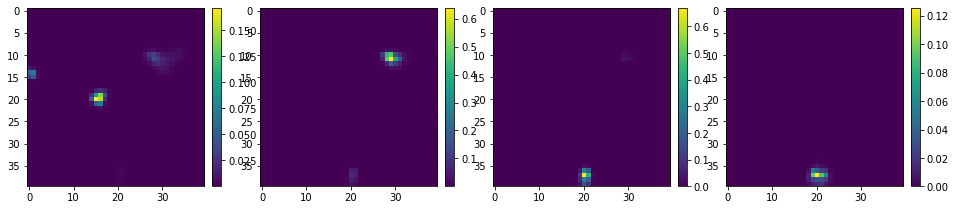

In [227]:
for _ in range(1):
    post, target_coords, scatter = get_pred()
    plt_imshow(post, target_coords = target_coords, cbar = True, **imkwargs)
    plt_imshow(post, cbar = True)
#     plt_imshow(post, target_coords = target_coords, cbar = True, ylog = True, **imkwargs)

3.381837191423106e-15 0.7584147936480303


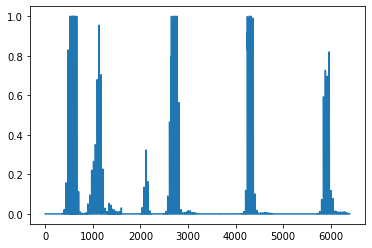

In [11]:
def get_alphas(post):
    print(post_min, post_max)
    post = ( post - post_min ) / post_max

    a, b = 50, 1
    alphas = 1 - b * np.exp( - a * post)
    
    return alphas

plt.plot(get_alphas(post).flatten())

In [62]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [13]:
x.shape, y.shape, z.shape, data.shape, visiblebox.shape, colors.shape

NameError: name 'x' is not defined

In [ ]:
y = normalize(data).reshape(-1)
x = np.arange(len(y))

plt.plot(x, y)

In [ ]:
def normalize(d):
    d -= d.min()
    d /= d.max()
    return d

In [ ]:
plt.plot(np.arange(len(data.flatten())), )
plt.show()

In [ ]:
print(x.shape, y.shape, z.shape, data.shape, visiblebox.shape, colors.shape)

In [ ]:
x,y,z = np.mgrid[1:10,3:18,0:5]
data = np.random.normal(0,10,[x.shape[0]-1,x.shape[1]-1,x.shape[2]-1])
visiblebox = np.random.choice([True],data.shape)

ax = plt.figure(figsize = (10, 10)).add_subplot(111,projection ='3d')
colors = plt.cm.plasma(normalize(data) )
colors[:,:,:,-1] = alpha = normalize(data) #np.full(data.shape, 0.2)
norm = matplotlib.colors.Normalize(vmin=0, vmax =1)

vox = ax.voxels(x,y,z,visiblebox,facecolors=colors,edgecolor=None)

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)

plt.show()

In [ ]:
# y = 1 - b*np.exp(-a*data)
y = np.power(data, 0.2)
y = y.flatten()
x = np.arange(len(y))

plt.plot(x, y)

In [ ]:
grid

In [ ]:


# x,y,z = np.meshgrid(np.arange(L+1), np.arange(L+1), np.arange(4+1))

grid, grid = np.meshgrid(np.linspace(0,1,L+1), np.linspace(0,1,L+1))

X =  np.tile(grid, (5,1,1)).T
Y =  np.tile(grid, (5,1,1)).T
Z =  np.array([np.full((L+1, L+1), m) for m in m_edges]).T


data = np.transpose(post, [1,2,0])
visiblebox = np.full_like(data, True)

ax = plt.figure(figsize = (10, 10)).add_subplot(111,projection ='3d')
# d = ((data - data.mean() ) / data.std())
# colors = plt.cm.plasma(normalize(data))
# colors[:,:,:,-1] = alpha = normalize(np.power(data, 0.2))

d = ((data - data.mean() ) / data.std())
colors = plt.cm.plasma(d)

norm = matplotlib.colors.Normalize(vmin=0, vmax = 1)
norm = matplotlib.colors.Normalize(vmin=post_min, vmax = post_max)


print(X.shape, Y.shape, Z.shape, data.shape, visiblebox.shape, colors.shape)

vox = ax.voxels(x,y,z,visiblebox,facecolors=colors,edgecolor=None)

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)

# plt.xlabel('x')
# plt.xticks([0,1,2], ['a', 'c',3])

plt.show()

In [ ]:
x,y,z = np.mgrid[1:10,3:18,0:5]
data = np.random.normal(0,10,[x.shape[0]-1,x.shape[1]-1,x.shape[2]-1])
visiblebox = np.random.choice([True],data.shape)

ax = plt.figure(figsize = (10, 10)).add_subplot(111,projection ='3d')
colors = plt.cm.plasma(normalize(data) )
colors[:,:,:,-1] = alpha = normalize(data) #np.full(data.shape, 0.2)
norm = matplotlib.colors.Normalize(vmin=0, vmax =1)

vox = ax.voxels(x,y,z,visiblebox,facecolors=colors,edgecolor=None)

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)

plt.show()

In [99]:
grid, grid = np.meshgrid(np.linspace(0,1,L+1), np.linspace(0,1,L+1))

X =  np.tile(grid, (5,1,1)).T
Y =  np.tile(grid, (5,1,1)).T
Z =  np.array([np.full((L+1, L+1), m) for m in m_edges]).T




tensor([1.7783e+10, 5.6234e+10, 1.7783e+11, 5.6234e+11])

In [117]:
x = y = np.linspace(0, 1, L)
z = m_centers.numpy()
data = np.transpose(post, [1,2,0])

In [118]:
x.shape, y.shape, z.shape, data.shape

((40,), (40,), (4,), (40, 40, 4))

In [104]:
np.linspace(0, 1, L).shape

(40,)

In [100]:
X.shape, Y.shape, Z.shape, data.shape

((41, 41, 5), (41, 41, 5), (41, 41, 5), (40, 40, 4))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [141]:
%matplotlib inline

(21, 5, 5)


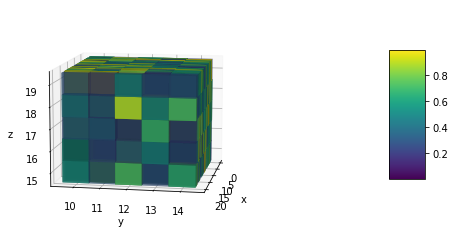

In [193]:

def cuboid_data(center, size=(1,1,1)):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(pos=(0,0,0), c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, data, cmap=plt.cm.viridis, cax=None, alpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    for i, xi in enumerate(x):
            for j, yi in enumerate(y):
                for k, zi, in enumerate(z):
                    plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alphas(i,j,k),  ax=ax)



    if cax !=None:
        cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')  
#         cbar.set_ticks(np.unique(data))
        # set the colorbar transparent as well
#         cbar.solids.set(alpha=alpha)              




# x and y and z coordinates
x = np.array(range(21)) #np.linspace(0,9,11) #
y = np.array(range(10,15))
z = np.array(range(15,20))
# data_value = np.random.randint(1,4, size=(len(x), len(y), len(z)) )
data_value = np.random.rand(len(x), len(y), len(z))

# x = y = np.arange(L) #np.linspace(0, 1, L)
# z = np.arange(len(m_centers)) #m_centers.numpy()
# data_value = np.transpose(post, [1,2,0])


print(data_value.shape)

fig = plt.figure(figsize=(10,4))



ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
# ax.set_aspect('equal')

plotMatrix(ax, x, y, z, data_value, cmap=plt.cm.viridis, cax = ax_cb)

ax.view_init(elev=10., azim=10.)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')




# plt.savefig(__file__+".png")
plt.show()

In [290]:
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

(40, 40, 4)


100%|██████████| 4/4 [00:54<00:00, 13.54s/it]


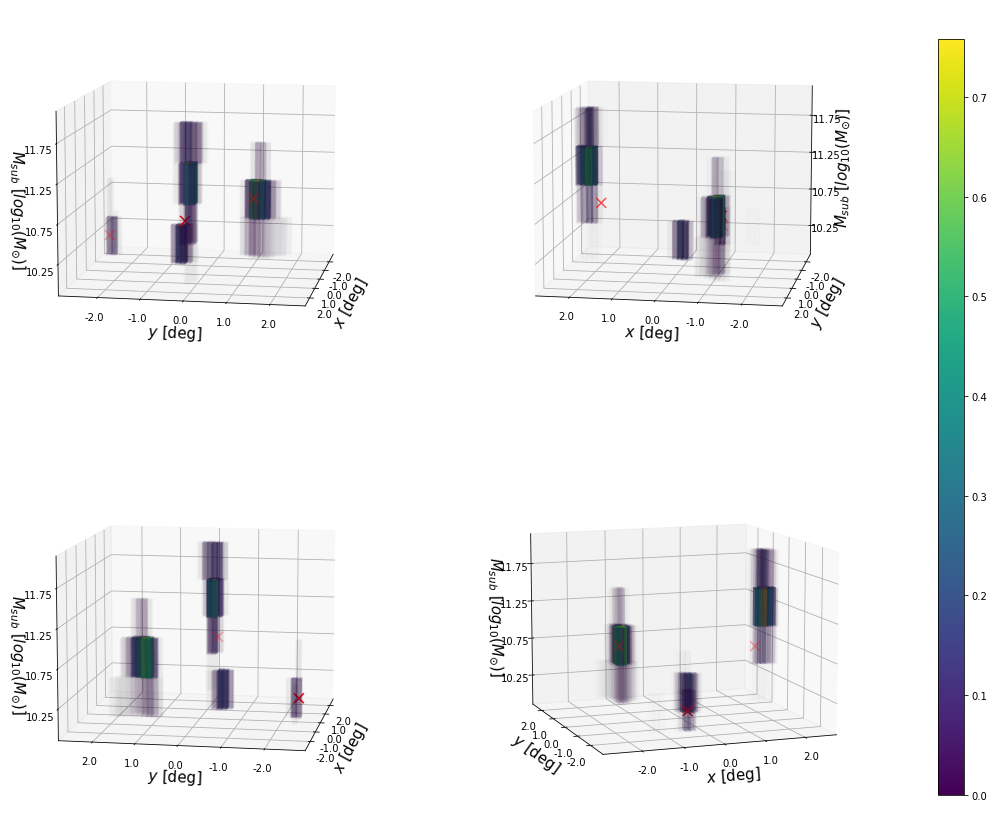

In [292]:

def cuboid_data(center, size=(1,1,1)):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(pos=(0,0,0), c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, data, cmap=plt.cm.viridis, cax=None, alpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    for i, xi in enumerate(x):
            for j, yi in enumerate(y):
                for k, zi, in enumerate(z):
                    plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alphas(i,j,k),  ax=ax)

# x and y and z coordinates
x = np.array(range(21)) #np.linspace(0,9,11) #
y = np.array(range(10,15))
z = np.array(range(15,20))
# data_value = np.random.randint(1,4, size=(len(x), len(y), len(z)) )
data_value = np.random.rand(len(x), len(y), len(z))

x = y = np.arange(L) #np.linspace(0, 1, L)
z = np.arange(len(m_centers)) #m_centers.numpy()
data_value = np.transpose(post, [1,2,0])

azims = [10., 100., 190., 250.]
# azims = [10.]

print(data_value.shape)

fig = plt.figure(figsize=(18,15))

for i, azim in enumerate(tqdm(azims)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    plotMatrix(ax, x, y, z, data_value)
    
    ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)
    
    ax.view_init(elev=10., azim=azim)
    
    labelsize = 15
    ax.set_xlabel(r'$x\ [\deg]$', fontsize = labelsize)
    ax.set_ylabel(r'$y\ [\deg]$', fontsize = labelsize)
    ax.set_zlabel(r'$M_{sub}\ [log_{10}(M_{\odot})]$', fontsize = labelsize)
    
    ax.set_xticks(np.linspace(0, L, 11)[1::2])
    ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
    ax.set_yticks(np.linspace(0, L, 11)[1::2])
    ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
    ax.set_zticks(z)
    ax.set_zticklabels(np.log10(m_centers.numpy()))
    
    
    


fig.subplots_adjust(right=0.8)
ax_cb = fig.add_axes([0.85, 0.15, 0.02, 0.7])

norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
cbar = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.viridis,
                                norm=norm,
                                orientation='vertical')  

plt.savefig('fig.png',bbox_inches='tight')
plt.show()

Text(0, 0.5, '$x\\ [\\deg]$')

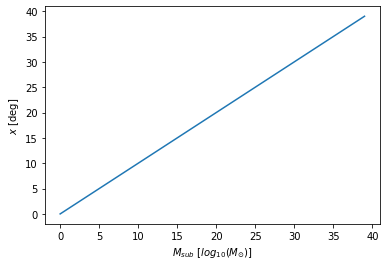

In [253]:
plt.plot(x.flatten())
plt.xlabel(r'$M_{sub}\ [log_{10}(M_{\odot})]$')
plt.ylabel(r'$x\ [\deg]$')

In [239]:
np.log10(m_edges.numpy())

array([10. , 10.5, 11. , 11.5, 12. ], dtype=float32)

In [232]:
m_edges

tensor([1.0000e+10, 3.1623e+10, 1.0000e+11, 3.1623e+11, 1.0000e+12])

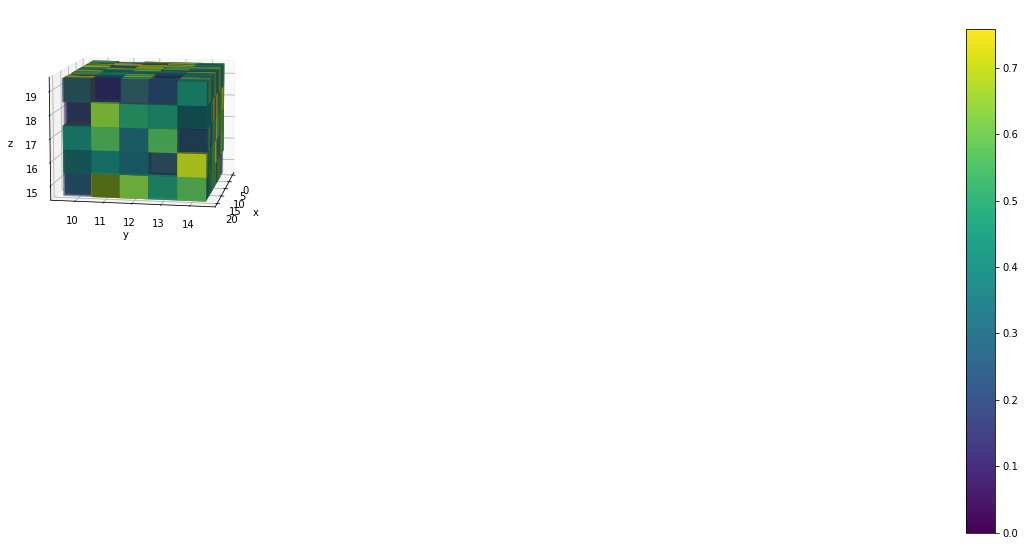

In [159]:
x = np.array(range(21)) #np.linspace(0,9,11) #
y = np.array(range(10,15))
z = np.array(range(15,20))
# data_value = np.random.randint(1,4, size=(len(x), len(y), len(z)) )
data_value = np.random.rand(len(x), len(y), len(z))

fig = plt.figure(figsize=(20,10))

for i, azim in enumerate(tqdm([10])):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    plotMatrix(ax, x, y, z, data_value)
    ax.view_init(elev=10., azim=azim)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xticks()


fig.subplots_adjust(right=0.8)
ax_cb = fig.add_axes([0.85, 0.15, 0.02, 0.7])

norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
cbar = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.viridis,
                                norm=norm,
                                orientation='vertical')  

plt.show()

(21, 5, 5)


<IPython.core.display.Javascript object>


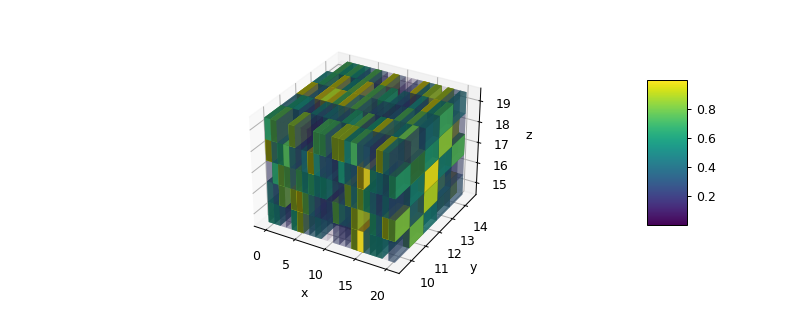

In [98]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colorbar
import matplotlib.colors

def cuboid_data(center, size=(1,1,1)):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
#     print(o)
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(pos=(0,0,0), c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, data, cmap=plt.cm.viridis, cax=None, alpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    for i, xi in enumerate(x):
            for j, yi in enumerate(y):
                for k, zi, in enumerate(z):
                    plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alphas(i,j,k),  ax=ax)



    if cax !=None:
        cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')  
#         cbar.set_ticks(np.unique(data))
        # set the colorbar transparent as well
#         cbar.solids.set(alpha=alpha)              




# x and y and z coordinates
x = np.array(range(21)) #np.linspace(0,9,11) #
y = np.array(range(10,15))
z = np.array(range(15,20))
# data_value = np.random.randint(1,4, size=(len(x), len(y), len(z)) )
data_value = np.random.rand(len(x), len(y), len(z))
print(data_value.shape)

fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
# ax.set_aspect('equal')

plotMatrix(ax, x, y, z, data_value, cmap=plt.cm.viridis, cax = ax_cb)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# plt.savefig(__file__+".png")
plt.show()

In [54]:
def normalize(d):
    d -= d.min()
    return d / d.max()